In [1]:
%pip install interpret

BONUS

1. EBM

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.model_selection import GridSearchCV

train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('test.csv')


In [3]:
def evaluate_model(y_true, y_pred, y_prob, dataset_name="Dataset"):
    print(f"\nEvaluation Metrics for {dataset_name}:")
    print(classification_report(y_true, y_pred))

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name='Model'):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()

In [4]:
from interpret.glassbox import ExplainableBoostingClassifier

# Initialize EBM
ebm = ExplainableBoostingClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_bins': [128]
}

# Perform grid search
grid_search = GridSearchCV(estimator=ebm, param_grid=param_grid, scoring='precision', cv=10, n_jobs=-1)

X_train = train_df.drop(columns=['Realornot'])
y_train = train_df['Realornot']
X_test = test_df.drop(columns=['Realornot'])
y_test = test_df['Realornot']

grid_search.fit(X_train, y_train)

best_params_ebm = grid_search.best_params_
print(f"Best hyperparameters: {best_params_ebm}")

mean_precision = grid_search.cv_results_['mean_test_score'].mean()
std_precision = grid_search.cv_results_['std_test_score'].mean()
print(f"Mean precision: {mean_precision:.4f} (+/- {std_precision:.4f})")

Best hyperparameters: {'learning_rate': 0.01, 'max_bins': 128}
Mean precision: 0.7819 (+/- 0.0115)



Evaluation Metrics for Training:
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      7106
           1       0.80      0.85      0.83      7137

    accuracy                           0.82     14243
   macro avg       0.82      0.82      0.82     14243
weighted avg       0.82      0.82      0.82     14243



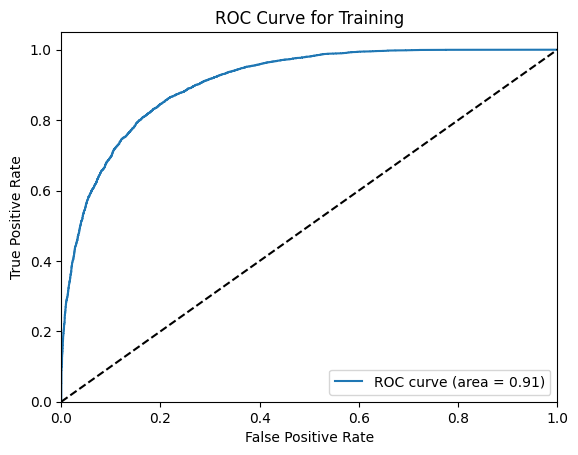

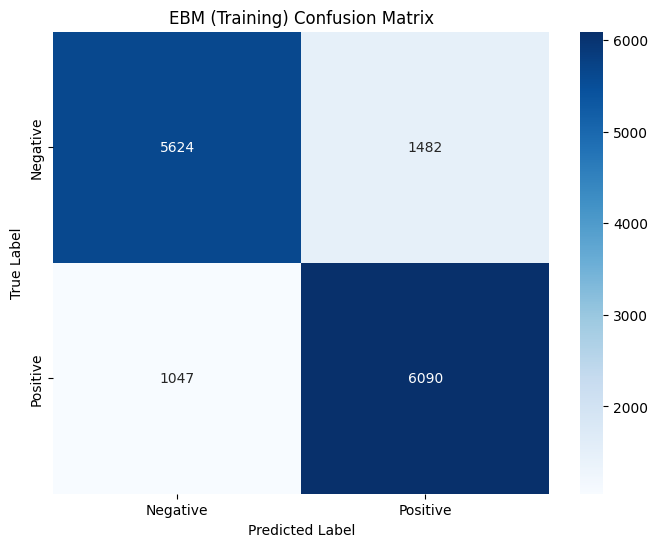


Evaluation Metrics for Test:
              precision    recall  f1-score   support

           0       0.75      0.68      0.72      1172
           1       0.72      0.78      0.74      1200

    accuracy                           0.73      2372
   macro avg       0.73      0.73      0.73      2372
weighted avg       0.73      0.73      0.73      2372



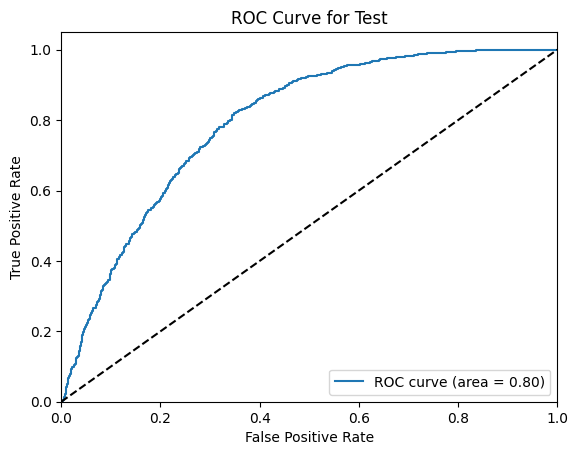

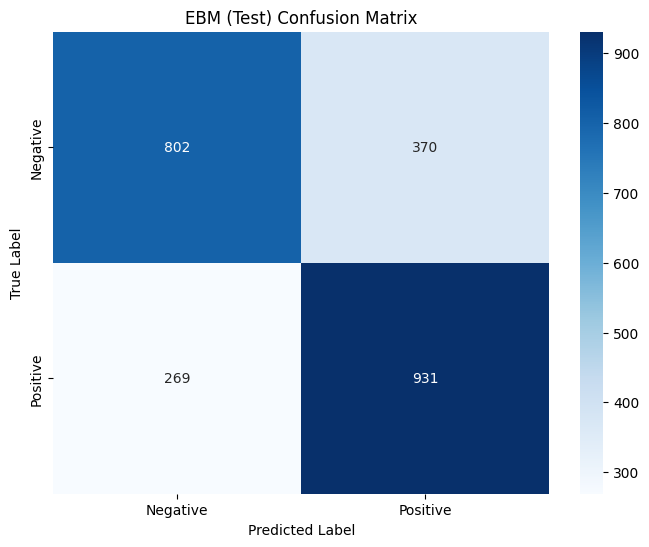

In [5]:
# Train model with best parameters
best_ebm = ExplainableBoostingClassifier(
    learning_rate=best_params_ebm['learning_rate'],
    max_bins=best_params_ebm['max_bins'],
    random_state=42
)

best_ebm.fit(X_train, y_train)

# Make predictions
ebm_train_pred = best_ebm.predict(X_train)
ebm_train_prob = best_ebm.predict_proba(X_train)[:,1]
ebm_test_pred = best_ebm.predict(X_test)
ebm_test_prob = best_ebm.predict_proba(X_test)[:,1]

# Evaluate model
evaluate_model(y_train, ebm_train_pred, ebm_train_prob, dataset_name="Training")
plot_confusion_matrix(y_train, ebm_train_pred, model_name='EBM (Training)')

evaluate_model(y_test, ebm_test_pred, ebm_test_prob, dataset_name="Test") 
plot_confusion_matrix(y_test, ebm_test_pred, model_name='EBM (Test)')